In [1]:
%matplotlib inline

# Extending Character Level Recurrent Networks for Sequence Generation

We extend the approach outlined in `char_rnn_one_file_code_gen.ipynb` to improve efficiency and to accomodate other recurrent layer types. Notably, we introduce:

* Training will use multiple files instead of a single file
* Validation sets will be introduced to avoid overfitting on our training data
* Mini-batches for training speedup

Our outlined task is still the same.

**Given a sequence of characters, predict the next likely character in the sequence.**

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from json import load
from math import floor
from time import time
from statistics import mean

## Preparing the Data

We will be training on a set of 180 preprocessed Python files (and validating on a set of 20 other files) arbitrarily sampled from [GitHub BigQuery Python Extracts](https://bigquery.cloud.google.com/table/fh-bigquery:github_extracts.contents_py_201802snap?pli=1).

We limit the characters that our neural network can produce to a subset of standard ASCII.
* `ORD 2*, 3*, 9, 10, 32-126`
  * `ORD 0` for padding (special, used in batch_size > 1 with variable length sequences)
  * `ORD 2` for start of text (special, predicted sequence start)
  * `ORD 3` for end of text (special, sequence prediction ends)
  * `ORD 9` horizontal tab "\t"
  * `ORD 10` NL line feed, new line "\n"
  * `ORD 32-126` Space, Punctuation, Digits, English Letters

NOTE: The full dataset contains files written using non standard characters. For the models in this notebook, we ensure that all Python files within our dataset are composed only of ASCII characters that we accept.

In [3]:
# Possible Characters for neural network
VALID_UNICODE_IDS = (0, 2, 3, 9, 10) + tuple(range(32, 127))
for uid in VALID_UNICODE_IDS:
    if uid <= 32:
        print("{}: {}".format(uid, repr(chr(uid))))
        continue
    print(chr(uid), end="")
print()

# Special Characters
PAD = chr(0)
FILE_START = chr(2)
FILE_END = chr(3)

CHARACTERS = set(chr(id) for id in VALID_UNICODE_IDS)
INT2CHAR = dict(enumerate(CHARACTERS))
CHAR2INT = {char: idx for idx, char in INT2CHAR.items()}

with open("./data/train.json", "r") as f:
    training_data = load(f)
with open("./data/validate.json", "r") as f:
    validation_data = load(f)

print("~" * 25)
print("Num Training Files: {}".format(len(training_data)))
print("Num Validation Files: {}".format(len(validation_data)))

# SANITY_CHECK, MEMORIZE TWO FILES
#with open("./data/test.py", "r") as f:
#    text = f.read()
#with open("./data/test2.py", "r") as f:
#    text2 = f.read()
#training_data = (
#    (FILE_START, ) + tuple(text) + (FILE_END,),
#    (FILE_START, ) + tuple(text2) + (FILE_END,),
#)
#validation_data = training_data[:]
#print("SANITY Training Files: {}".format(len(training_data)))
#print("SANITY Validation Files: {}".format(len(validation_data)))

0: '\x00'
2: '\x02'
3: '\x03'
9: '\t'
10: '\n'
32: ' '
!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
~~~~~~~~~~~~~~~~~~~~~~~~~
Num Training Files: 180
Num Validation Files: 20


Let's randomly take a look at what is contained within our training data.

In [4]:
train_sample = random.choice(training_data)
print(len(train_sample))
print("".join(train_sample))
# print([repr(v) for v in train_sample])

634
from common.numpy_fast import clip


def rate_limit(new_value, last_value, dw_step, up_step):
    return clip(new_value, last_value + dw_step, last_value + up_step)


def learn_angle_offset(lateral_control, v_ego, angle_offset, d_poly, y_des,
    steer_override):
    min_offset = -1.0
    max_offset = 1.0
    alpha = 1.0 / 36000.0
    min_learn_speed = 1.0
    alpha_v = alpha * max(v_ego - min_learn_speed, 0.0) / (1.0 + 0.5 * abs(
        y_des))
    if lateral_control and not steer_override:
        angle_offset += d_poly[3] * alpha_v
        angle_offset = clip(angle_offset, min_offset, max_offset)
    return angle_offset



# Utilize CUDA & GPU

Training neural networks can be slow. Utilize GPUs if they are available to us.

In [5]:
device = torch.device("cpu")
HAS_CUDA = False
if torch.cuda.is_available():
    HAS_CUDA = True
    print("CUDA is available")
    print(" • Number of CUDA devices: {}".format(torch.cuda.device_count()))
    device = torch.device("cuda")
    print(" • Current Device Name: {}".format(torch.cuda.get_device_name(device)))
    print(" • Device CUDA Capability: {}".format(torch.cuda.get_device_capability(device)))

else:
    print("CUDA is not available.")

# force GPU off.
# HAS_CUDA = False
# device = torch.device("cpu")

CUDA is available
 • Number of CUDA devices: 1
 • Current Device Name: TITAN Xp
 • Device CUDA Capability: (6, 1)


## Batching Sliding Window Algorithm

We extend from the previously created sliding window algorithm, but rather than predicting the next character, we output the next sequence Y as one character shifted over:

* Given some iterable, we want a generator that yields X, Y pairs for evaluation.
* We want a sequence of a given context length as X, and the sequence one character shifted over as Y.

We want our sliding window algorithm to yield these pairs in batches, for more efficient computation. Iterable is no longer a single file, but an iterator over multiple files.

In [6]:
def batch_sliding_window_generator(files_iterable, max_batch_size, max_window_size=None, gen_forever=True):
    """Sliding window generator for batching files of ASCII characters"""
    inp_batch = []
    target_batch = []
    while True:
        for iterable in files_iterable:
            inp_batch = []
            target_batch = []

            if max_window_size is None:
                window_size = len(iterable)
            else:
                window_size = min(max_window_size, len(iterable) - 1)

            chunk_windows = list(range(0, len(iterable) - window_size + 1))
            random.shuffle(chunk_windows)
            while chunk_windows:
                start_index = chunk_windows.pop()
                end_index = start_index + window_size + 1
                chunk = iterable[start_index:end_index]
                if chunk[:-1] and chunk[1:]:
                    if inp_batch and len(inp_batch[0]) != len(chunk[:-1]):
                        # diagnose training issues
                        import pdb; pdb.set_trace()
                        continue
                    inp_batch.append(chunk[:-1])
                    target_batch.append(chunk[1:])
                
                if len(inp_batch) >= max_batch_size:
                    yield inp_batch, target_batch
                    inp_batch = []
                    target_batch = []
            if inp_batch:
                yield inp_batch, target_batch
        if not gen_forever:
            break

Here are the first few generator outputs.
Note the provided batch sizes and window sizes.

In [7]:
max_batch_size = 2
max_window_size = 15

gen = batch_sliding_window_generator(training_data, max_batch_size, max_window_size)
for i in range(2):
    inp, target = next(gen)
    print("Batch {}".format(i))
    print("Input:")
    print(*inp, sep="\n")
    print("Target: ")
    print(*target, sep="\n")
    print("~" * 25)


Batch 0
Input:
[' ', 'd', 'e', 'f', ' ', '_', '_', 'i', 'n', 'i', 't', '_', '_', '(', 's']
['e', 'c', 'u', 'r', 'r', 'e', 'n', 'c', 'e', ' ', 'p', 'l', 'o', 't', ' ']
Target: 
['d', 'e', 'f', ' ', '_', '_', 'i', 'n', 'i', 't', '_', '_', '(', 's', 'e']
['c', 'u', 'r', 'r', 'e', 'n', 'c', 'e', ' ', 'p', 'l', 'o', 't', ' ', 'u']
~~~~~~~~~~~~~~~~~~~~~~~~~
Batch 1
Input:
['f', ' ', 'n', 'u', 'm', 'b', 'e', 'r', '\n', ' ', ' ', ' ', ' ', ' ', ' ']
['g', 't', 'h', '!', ' ', 'F', 'o', 'r', 'm', 'a', 'l', 'l', 'y', ',', ' ']
Target: 
[' ', 'n', 'u', 'm', 'b', 'e', 'r', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
['t', 'h', '!', ' ', 'F', 'o', 'r', 'm', 'a', 'l', 'l', 'y', ',', ' ', 'n']
~~~~~~~~~~~~~~~~~~~~~~~~~


Let's see how many batches we have to work with.

In [8]:
check_batch_size = 1
check_window_size = None

gen = batch_sliding_window_generator(training_data, check_batch_size, check_window_size, gen_forever=False)

batch_item_sizes = {}
batch_sizes = {}
batch_counter = 0
for inp, target in gen:
    batch_counter += 1
    batch_size = len(inp[0])
    for batch_item in inp:
        assert len(batch_item) == batch_size
        batch_item_sizes[len(batch_item)] = batch_item_sizes.get(len(batch_item), 0) + 1
    batch_sizes[batch_size] = batch_sizes.get(batch_size, 0 ) + 1
print("Batches: {}".format(batch_counter))
for k, v in batch_item_sizes.items():
    print(" • {} batch_item of sequence length {}".format(v, k))

Batches: 180
 • 1 batch_item of sequence length 7308
 • 1 batch_item of sequence length 1558
 • 1 batch_item of sequence length 295
 • 1 batch_item of sequence length 348
 • 1 batch_item of sequence length 76
 • 1 batch_item of sequence length 852
 • 1 batch_item of sequence length 4845
 • 1 batch_item of sequence length 87
 • 1 batch_item of sequence length 36
 • 1 batch_item of sequence length 174
 • 1 batch_item of sequence length 587
 • 1 batch_item of sequence length 2955
 • 1 batch_item of sequence length 3783
 • 1 batch_item of sequence length 1518
 • 1 batch_item of sequence length 1488
 • 1 batch_item of sequence length 17322
 • 1 batch_item of sequence length 1523
 • 1 batch_item of sequence length 6478
 • 1 batch_item of sequence length 1842
 • 1 batch_item of sequence length 6775
 • 1 batch_item of sequence length 160
 • 1 batch_item of sequence length 3079
 • 1 batch_item of sequence length 75
 • 1 batch_item of sequence length 1504
 • 1 batch_item of sequence length 1800


## Batch Characters to Tensors

Our batch of inputs and outputs must be converted into Tensors for training.

We follow the default matrix convention used by the PyTorch comunity.

> Tensor’s data will be of size `T x B x *`, where `T` is the length of the longest sequence and `B` is the batch size. 

To make a batch training example, we join a bunch our sequences of one-hot characters into a matrix of size `(window_size, batch_size, num_chars)`.

In [9]:
def char_to_tensor(char, num_chars=len(CHARACTERS)):
    tensor = torch.zeros(1, 1, num_chars, device=device)
    tensor[0][0][CHAR2INT[char]] = 1
    return tensor

def charseq_to_tensor(charseq, num_chars=len(CHARACTERS)):
    window_size = len(charseq)
    tensor = torch.zeros(window_size, 1, num_chars, device=device)
    for seq_idx, seq_item in enumerate(charseq):
        tensor[seq_idx][0][CHAR2INT[seq_item]] = 1
    return tensor

def charseqs_to_tensor(charseqs, num_chars=len(CHARACTERS)):
    batch_size = len(charseqs)
    window_size = max([len(v) for v in charseqs])
    assert all(len(v) == window_size for v in charseqs)
    
    tensor = torch.zeros(window_size, batch_size, num_chars, device=device)
    
    for batch_elm_idx, batch_item in enumerate(charseqs):
        for seq_idx, seq_item in enumerate(batch_item):
            tensor[seq_idx][batch_elm_idx][CHAR2INT[seq_item]] = 1
    return tensor

The tensor inputs and outputs for the generator function we defined earlier are shown here.

In [10]:
gen = batch_sliding_window_generator(training_data, max_batch_size, max_window_size)

inp_val, target_val = next(gen)
inp_tensor = charseqs_to_tensor(inp_val)
target_tensor = charseqs_to_tensor(target_val)

print("max_batch_size: {}, max_window_size: {}".format(max_batch_size, max_window_size))
print("~" * 25)
print(*inp_val, sep="\n")
print(inp_tensor.size())
#_, idxs = inp_tensor.topk(1)
print(*target_val, sep="\n")
print(target_tensor.size())

max_batch_size: 2, max_window_size: 15
~~~~~~~~~~~~~~~~~~~~~~~~~
[' ', 'a', 'n', 'd', ' ', 'y', ',', ' ', 'c', 'a', 'l', 'c', 'u', 'l', 'a']
['h', ' ', 't', 'i', 'm', 'e', ' ', 's', 'e', 'r', 'i', 'e', 's', '.', '\n']
torch.Size([15, 2, 100])
['a', 'n', 'd', ' ', 'y', ',', ' ', 'c', 'a', 'l', 'c', 'u', 'l', 'a', 't']
[' ', 't', 'i', 'm', 'e', ' ', 's', 'e', 'r', 'i', 'e', 's', '.', '\n', ' ']
torch.Size([15, 2, 100])


## Creating the Network

We are going to create our recurrent neural network. Rather than using our own pure recurrent neural network defined in the last notebook, we will be using the recurrent layers provided by PyTorch.

* **RNN**: [Recurrent Neural Network](https://pytorch.org/docs/stable/nn.html#rnn)
* **GRU**: [Gated Recurrent Unit](https://pytorch.org/docs/stable/nn.html#gru)
* **LSTM**: [Long Short-Term Memory](https://pytorch.org/docs/stable/nn.html#lstm)

Our model is composed of the following:
0. Recurrent Layer (RNN/GRU/LSTM)
0. Linear Layer
0. Softmax Activation

In [11]:
class CharRNN(nn.Module):
    def __init__(self, input_size, output_size,
                 hidden_size=128, recurrent_type="LSTM", recurrent_layers=1, recurrent_dropout=0):
        super(CharRNN, self).__init__()

        self.recurrent_type = recurrent_type.upper()
        self.hidden_size = hidden_size
        self.recurrent_layers = recurrent_layers
        self.recurrent_dropoout = recurrent_dropout
        
        rn_kwargs = {
            "input_size": input_size,
            "hidden_size": hidden_size,
            "num_layers": recurrent_layers,
            "dropout": recurrent_dropout,
        }
        
        if self.recurrent_type == "RNN":
            self.rnn = nn.RNN(**rn_kwargs)
        elif self.recurrent_type == "LSTM":
            self.rnn = nn.LSTM(**rn_kwargs)
        elif self.recurrent_type == "GRU":
            self.rnn = nn.GRU(**rn_kwargs)
        else:
            raise "Invalid recurrent layer type: {}".format(recurrent_type)
        
        self.decoder = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, inp_val, hidden):
        for_decoder, hidden = self.rnn(inp_val, hidden)
        for_softmax = self.decoder(for_decoder)
        output = self.softmax(for_softmax)
        return output, hidden
    
    def init_hidden(self, batch_size):
        if self.recurrent_type == "LSTM":
            return (
                torch.zeros(self.recurrent_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.recurrent_layers, batch_size, self.hidden_size, device=device)
            )
        return torch.zeros(self.recurrent_layers, batch_size, self.hidden_size, device=device)

Initilize this network with values appropriate for the character prediction task.

In [12]:
n_chars = len(CHARACTERS)
batch_size = 4

char_rnn = CharRNN(n_chars, n_chars)
if HAS_CUDA:
    char_rnn.cuda(device)

Before each batch, the RNN's hidden state should be initialized.

In [13]:
max_window_size = 20
gen = batch_sliding_window_generator(
    training_data, max_batch_size, max_window_size, gen_forever=False)
inp_charseq, target_charseq = next(gen)
inp_val = charseqs_to_tensor(inp_charseq)
_, batch_size, _ = inp_val.size()
hidden = char_rnn.init_hidden(batch_size)

output, hidden = char_rnn(inp_val, hidden)
print("Input:", inp_val.size())
print("Output:", output.size())

Input: torch.Size([20, 2, 100])
Output: torch.Size([20, 2, 100])


## Preparing to Train our Model

We will create a helper function to convert the network predicted output back to a human readable character.

In [14]:
def readable_from_output(output):
    """Convert the network output predictions back to readable values."""
    _, top_i = output.topk(1)
    window_size, batch_size, _ = top_i.size()
    batches_chars = []
    for batch_ele_idx in range(batch_size):
        batch_chars = []
        for seq_ele_idx in range(window_size):
            char_idx = top_i[seq_ele_idx][batch_ele_idx].item()
            char = INT2CHAR[char_idx], char_idx
            batch_chars.append(char)
        batches_chars.append(batch_chars)
    return batches_chars

def pretty_print_output(batches_chars):
    for seq_idx, seq in enumerate(batches_chars):
        print("Batch {}:".format(seq_idx), "".join([char for char, _ in seq]))

batches_chars = readable_from_output(output)
pretty_print_output(batches_chars)

Batch 0: owwwwwwwwwwwwowKoKow
Batch 1: wwwwKwwvoooooooooooo


Show the network some examples, have it make predictions, and then inform the network when the predictions are correct.
We have a classification problem, so Negative Log Likelihood loss is appropriate.

For classifing input into `C` number of classes, the following loss functions are useful:

* **Cross Entropy Loss**: [CrossEntropyLoss docs](https://pytorch.org/docs/stable/nn.html#crossentropyloss)
* **Negative Log Likelihood Loss**: [NLLLoss docs](https://pytorch.org/docs/stable/nn.html#nllloss)

In [15]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

Each training loop will:
0. Create input and target tensors
0. Initialize a zerored hidden state
0. Read each letter in and keep the hidden state for the next letter
0. Compare the final output to the target
0. Back-propagate
0. Return the output and loss

In [16]:
def train(target_tensor, input_tensor, optimizer):
    window_size, batch_size, _ = input_tensor.size()
    hidden = char_rnn.init_hidden(batch_size)
    
    # Set model gradients to zero
    char_rnn.zero_grad()
    loss = 0
    
    hidden = char_rnn.init_hidden(batch_size)
    correct = []
    for i in range(window_size):
        output, hidden = char_rnn(input_tensor.narrow(0, i, 1), hidden)
        _, loss_output_tensor = target_tensor[i].topk(1)
        # diagnose training issues
        # import pdb; pdb.set_trace()

        loss += criterion(output.view(batch_size, -1), loss_output_tensor.view(-1))
    
    loss.backward()
    optimizer.step()
    
    return output, loss.item() / window_size

### Evaluation
We want to also evaluate the effectiveness of our model on a validation set, without updating the model.

This is done in the following function.

In [17]:
def evaluate(target_tensor, input_tensor):
    window_size, batch_size, _ = input_tensor.size()
    hidden = char_rnn.init_hidden(batch_size)
    
    # Set model gradients to zero
    char_rnn.zero_grad()
    loss = 0
    match = []
    
    hidden = char_rnn.init_hidden(batch_size)
    for i in range(window_size):
        output, hidden = char_rnn(input_tensor.narrow(0, i, 1), hidden)
        _, target_character = target_tensor[i].topk(1)
        _, predict_character = output.topk(1)
        
        # import pdb; pdb.set_trace()

        for batch_match in target_character.view(-1) == predict_character.view(-1):
            match.append(batch_match.item())
        
        loss += criterion(output.view(batch_size, -1), target_character.view(-1))
    
    # loss.backward()
    accuracy = mean(match)
    return accuracy, loss.item() / window_size

## Training our Model

Let's train our model now.

In [18]:
# Initialize required variables
n_chars = len(CHARACTERS)
max_batch_size = 1
char_rnn = CharRNN(n_chars, n_chars, recurrent_type="LSTM")
if HAS_CUDA:
    char_rnn.cuda(device)
learning_rate = 0.001
char_rnn_optimizer = torch.optim.Adam(char_rnn.parameters(), lr=learning_rate)

# Helper function
def time_since(since):
    delta = time() - since
    sec = int(delta)
    mins = floor(sec / 60)
    sec -= mins * 60
    return "{}m {:0>2d}s".format(mins, sec)

# Keep track of all the trainng that is done
train_epoch_losses = []
eval_epoch_losses = []
batch_iter_idx = 0

In [19]:
# variable which can change in-between trainng
n_epochs = 100
print_every_train = 47
# print_every_train = 1
print_every_epoch = 1
max_window_size = None

In [20]:
start = time()

for epoch_idx in range(n_epochs):
    # This generator will terminate when it finishes the file.
    gen = batch_sliding_window_generator(
        training_data, max_batch_size, max_window_size, gen_forever=False)
    for input_char_seq, target_char_seq in gen:
        # diagnose training issues
        #import pdb; pdb.set_trace()
    
        input_tensor = charseqs_to_tensor(input_char_seq)
        target_tensor = charseqs_to_tensor(target_char_seq)
        
        pred_output, train_loss = train(target_tensor, input_tensor, char_rnn_optimizer)

        if batch_iter_idx % print_every_train == 0:            
            print("Epoch {:1d} {:.1f}%: iter {:5d} ({}) | Train Loss: {:.5f}".format(
                len(train_epoch_losses), epoch_idx/n_epochs * 100, batch_iter_idx,
                time_since(start), train_loss))
        batch_iter_idx += 1

    # Add current loss avg to list of losses after each epoch
    train_epoch_losses.append(train_loss)

    # Run our model on our validation data set to determine validation loss and accuracy
    gen = batch_sliding_window_generator(
        validation_data, 1, max_window_size, gen_forever=False)
    
    eval_accuracies = []
    eval_losses = []
    for input_char_seqs, target_char_seqs in gen:
        input_tensor = charseqs_to_tensor(input_char_seqs)
        target_tensor = charseqs_to_tensor(target_char_seqs)
        eval_accuracy, eval_loss = evaluate(target_tensor, input_tensor)
        eval_accuracies.append(eval_accuracy)
        eval_losses.append(eval_loss)

    mean_eval_loss = mean(eval_losses)
    mean_eval_acc = mean(eval_accuracies)

    eval_epoch_losses.append(mean_eval_loss)
    
    if len(train_epoch_losses) % print_every_epoch == 0:
        print("> Epoch {:1d} {:.1f}%: ({}) | Train Loss: {:.5f}, Mean Eval Loss: {:.5f}, Mean Acc: {:.2f}".format(
            len(train_epoch_losses), epoch_idx/n_epochs * 100,
            time_since(start), train_loss, mean_eval_loss, mean_eval_acc))
    torch.save(char_rnn.state_dict(), "./models/char-rnn-epoch-{}-loss-{}.hdf5".format(
        len(train_epoch_losses), mean_eval_loss))

#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()



Epoch 0 0.0%: iter     0 (0m 04s) | Train Loss: 4.61060
Epoch 0 0.0%: iter    47 (1m 52s) | Train Loss: 3.34160
Epoch 0 0.0%: iter    94 (3m 27s) | Train Loss: 3.22136
Epoch 0 0.0%: iter   141 (5m 37s) | Train Loss: 3.56943
> Epoch 1 0.0%: (7m 22s) | Train Loss: 3.62499, Mean Eval Loss: 3.27614, Mean Acc: 0.21
Epoch 1 1.0%: iter   188 (7m 32s) | Train Loss: 3.57865
Epoch 1 1.0%: iter   235 (9m 24s) | Train Loss: 4.86477
Epoch 1 1.0%: iter   282 (11m 41s) | Train Loss: 3.13480
Epoch 1 1.0%: iter   329 (13m 13s) | Train Loss: 2.92207
> Epoch 2 1.0%: (14m 44s) | Train Loss: 3.55555, Mean Eval Loss: 3.10549, Mean Acc: 0.23
Epoch 2 2.0%: iter   376 (15m 14s) | Train Loss: 3.09847
Epoch 2 2.0%: iter   423 (16m 58s) | Train Loss: 2.84394
Epoch 2 2.0%: iter   470 (19m 15s) | Train Loss: 3.28965
Epoch 2 2.0%: iter   517 (20m 53s) | Train Loss: 2.95407
> Epoch 3 2.0%: (22m 07s) | Train Loss: 3.40122, Mean Eval Loss: 2.97849, Mean Acc: 0.26
Epoch 3 3.0%: iter   564 (22m 51s) | Train Loss: 2.80935

Epoch 26 26.0%: iter  4700 (192m 48s) | Train Loss: 2.32926
Epoch 26 26.0%: iter  4747 (194m 29s) | Train Loss: 2.19069
Epoch 26 26.0%: iter  4794 (196m 46s) | Train Loss: 2.30727
Epoch 26 26.0%: iter  4841 (198m 29s) | Train Loss: 1.58768
> Epoch 27 26.0%: (199m 32s) | Train Loss: 1.95596, Mean Eval Loss: 2.05868, Mean Acc: 0.46
Epoch 27 27.0%: iter  4888 (200m 21s) | Train Loss: 1.51783
Epoch 27 27.0%: iter  4935 (202m 06s) | Train Loss: 1.70929
Epoch 27 27.0%: iter  4982 (204m 19s) | Train Loss: 1.67823
Epoch 27 27.0%: iter  5029 (206m 10s) | Train Loss: 2.22553
> Epoch 28 27.0%: (206m 55s) | Train Loss: 1.96751, Mean Eval Loss: 2.05220, Mean Acc: 0.47
Epoch 28 28.0%: iter  5076 (208m 10s) | Train Loss: 1.97790
Epoch 28 28.0%: iter  5123 (209m 44s) | Train Loss: 1.73230
Epoch 28 28.0%: iter  5170 (211m 57s) | Train Loss: 1.69143
Epoch 28 28.0%: iter  5217 (213m 54s) | Train Loss: 2.03778
> Epoch 29 28.0%: (214m 18s) | Train Loss: 1.93866, Mean Eval Loss: 2.04860, Mean Acc: 0.47
Epoc

KeyboardInterrupt: 

## Plotting the Training Process
Plotting the historical loss from train_epoch_losses show how well the network is learning.

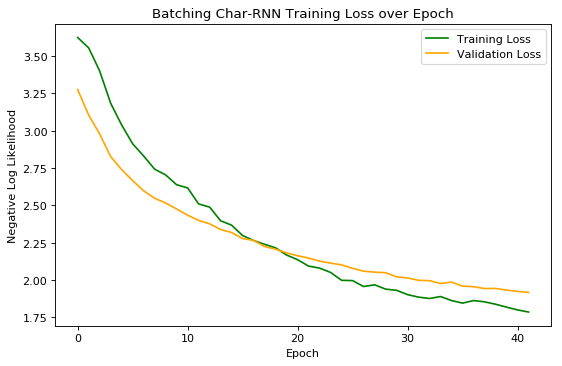

In [21]:
plt.figure(figsize=(8, 5), dpi=80)
plt.title("Batching Char-RNN Training Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood")
plt.plot(train_epoch_losses, color="green", label="Training Loss")
plt.plot(eval_epoch_losses, color="orange", label="Validation Loss")
plt.legend(loc="upper right")

## Using User Specified Input
Let's test this ourselves by supplying our own Python source code.

In [22]:
def generate(rnn, prime_str=FILE_START, print_output=True, max_gen_len=1000, temperature=None):
    hidden = rnn.init_hidden(1)
    if not prime_str.startswith(FILE_START):
        prime_str = FILE_START + prime_str

    input_seq = list(prime_str)
    # use priming sequence to construct the hidden state
    input_tensor = charseq_to_tensor(input_seq)
    for i in range(len(input_seq)):
        output, hidden = rnn(input_tensor.narrow(0, i, 1), hidden)
    
    if print_output:
        print("".join(input_seq))
        print("~~~~Predict~~~~")
        print("".join(input_seq))

    # predict until max_len or FILE_END character is reached
    predicted = input_seq[:]
    for i in range(max_gen_len):
        if temperature is not None:
            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
            char = INT2CHAR[top_i.item()]
        else:
            _, pred_char_idx = output.topk(1)
            char = INT2CHAR[pred_char_idx.item()]
        if print_output:
            print(char, end="")
        predicted.append(char)
        if char == FILE_END:
            return predicted
        input_tensor = char_to_tensor(char)
        output, hidden = rnn(input_tensor, hidden)
    
    if print_output:
        print("~max_gen_len reached~")
    return predicted

In [23]:
output = generate(char_rnn)


~~~~Predict~~~~

from self.abser.mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask_mask

What happens when you use this with your own text?

In [24]:
output = generate(char_rnn, "def", temperature=0.2)

def
~~~~Predict~~~~
def
 insting.

    def __init____init____init____init___ser__inate_== 'name', 'conting_configering', 'service', 'config', 'files')
    if self._config_content_contest_file_insting_contest_file_idsion_layer_cord_configer, context=
            'time', 'service', 'server')
        self._context_contest_file_inder_contest_contest_contest_contest_cast_id, config, config_contest_file_id)
        return self._contest_cast_contige_time
        if self._context_contest_file_indestingent()
            if not self.ald_case_inst_componert(self):
                                                        return self._contion_in

                                                                                                                                                                                                                                                                                                                                                                     